# Data Exploration for Different Fashion Recommendation

In [1]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf

import sys
# sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
# import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Zalando Data

In [2]:
train_dir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data/Train"
image_dir = "/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female"
train_file = "zalando_female_outfit_data_18k_and_new_modified_format_train.json"

In [3]:
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_data = json.load(fr)
print(f"Total {len(train_data)} data points")

Total 90847 data points


In [4]:
styles = []
for xy in train_data:
    styles.append(xy['outfit_occasion'])
print(Counter(styles))

Counter({'sporty': 13102, 'work': 13086, 'casual': 13062, 'party': 13059, 'athleisure': 13043, 'relax': 12879, 'travel': 12616})


In [58]:
def plot_outfit(outfit):
    items = outfit['item_ids']
    cats = outfit['low_level_cats']
    print(f"Total {len(items)} items in the outfit ({outfit['outfit_occasion']})")
    if len(items) <= 5:
        nrows, ncols = 1, len(items)
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
        for ii in range(ncols):
            item = items[ii]
            img = plt.imread(os.path.join(image_dir, item))
            imgplot = axis[ii].imshow(img)
            axis[ii].title.set_text(cats[ii])
            axis[ii].axis('off')
        plt.show()
    else:
        nrows, ncols = len(items) % 5 + 1, 5
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,10))
        count = 0
        for ii in range(nrows):
            for jj in range(ncols):
                item = items[count]
                img = plt.imread(os.path.join(image_dir, item))
                imgplot = axis[ii][jj].imshow(img)
                axis[ii][jj].title.set_text(cats[count])
                axis[ii][jj].axis('off')
                count += 1
                if count >= len(items):
                    break
        plt.show()


In [6]:
train_data[0]

{'gender': 'female',
 'outfit_id': '0288c17430a841c8aff4389f92fe3795',
 'outfit_img_url': 'https://mosaic04.ztat.net/vgs/media/outfit-image-mhq/dff2086f460332748b52a91216bb1329/0288c17430a841c8aff4389f92fe3795.jpg?imwidth=1000',
 'outfit_url': 'https://www.zalando.co.uk/outfits/WVMil2PCRZ6/',
 'item_ids': ['SIF21C000-Q11@13.jpg',
  'CA115O00F-Q11@11.jpg',
  'EV451H0M7-Q11@13.jpg'],
 'low_level_cats': ['shift-dress', 'trainer-shoes', 'bum-bag'],
 'mid_level_cats': ['dress', 'trainer-shoes', 'bag'],
 'high_level_cats': ['all-body', 'footwear', 'accessory'],
 'outfit_occasion': 'casual'}

Total 6 items in the outfit (work)


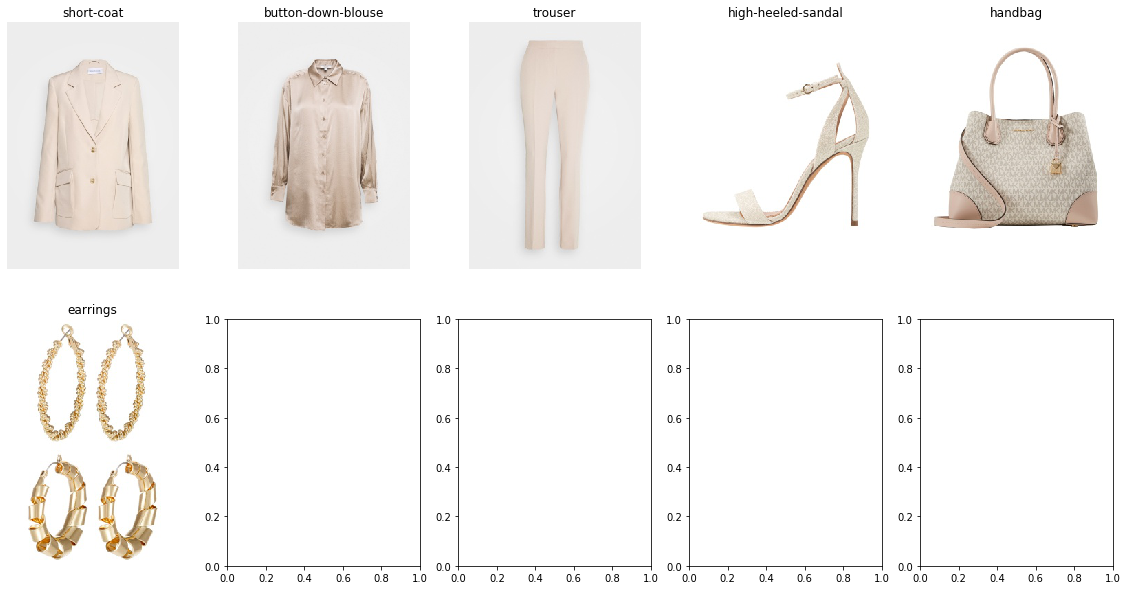

In [59]:
plot_outfit(train_data[5000])

## Polyvore Data

In [2]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
train_json = "train.json"
train_file = "compatibility_train.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

In [7]:
featfile = os.path.join(train_dir, 'train_hglmm_pca6000.txt')
desc2vecs = {}
text_dim = 6000
text_feat_dim = 6000
with open(featfile, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        vec = line.split(',')
        label = ','.join(vec[:-text_feat_dim])
        vec = np.array(
            [float(x) for x in vec[-text_feat_dim:]], np.float32)
        assert(len(vec) == text_dim)
        desc2vecs[label] = vec


In [8]:
len(desc2vecs)

183159

In [3]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    pv_train_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
with open(os.path.join(base_dir, outfit_file), 'r') as fr:
    pv_outfits = json.load(fr)
    
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])
    

In [6]:
categories = []
for k,v in pv_items.items():
    categories.append(v['semantic_category'])

Counter(categories).most_common()

[('shoes', 44850),
 ('jewellery', 41414),
 ('bags', 40717),
 ('tops', 32998),
 ('bottoms', 27670),
 ('all-body', 18478),
 ('outerwear', 17065),
 ('sunglasses', 9874),
 ('accessories', 6973),
 ('hats', 6071),
 ('scarves', 4898)]

 - pv_train_pos has only the positive (original) samples, 16995
 - train_X has both positive and negative (artificial) samples, 33990

In [4]:
len(pv_train_pos), len(train_X)

(16995, 33990)

Minimum and Maximum number of items in outfits

In [5]:
min([len(x) for x in train_X]), max([len(x) for x in train_X])

(2, 16)

In [6]:
min([len(x['items']) for x in pv_train_pos]), max([len(x['items']) for x in pv_train_pos])

(2, 16)

 - train_X has items numbered by outfit-id, e.g., outfitID_1, outfitID_2, ...
 - pv_train_pos has the original item-id

In [7]:
train_X[10000]

['225335785_1', '225335785_2', '225335785_3', '225335785_4', '225335785_5']

In [8]:
pv_train_pos[10000]

{'items': [{'item_id': '211212562', 'index': 1},
  {'item_id': '210479595', 'index': 2},
  {'item_id': '212523818', 'index': 3},
  {'item_id': '214980632', 'index': 4},
  {'item_id': '195016796', 'index': 5}],
 'set_id': '225335785'}

Create a dict to map train item_ids to their original ids

In [9]:
item_dict = {}
for ii, outfit in enumerate(pv_train_pos):
    items = outfit['items']
    mapped = train_X[ii]
    item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})

In [10]:
index = 10000
assert([item_dict[k] for k in train_X[index]] == [k['item_id'] for k in pv_train_pos[index]['items']])

In [11]:
pv_items['153967122']

{'url_name': 'gianvito rossi portofino suede sandals',
 'description': "Gianvito Rossi's hand-finished sandals have slim toe and ankle straps - one of the brand's signature shapes. They're crafted from black suede with a sleek heel. This versatile pair will work with everything from dresses to trousers. Shown here with: Anya Hindmarch Clutch, Givenchy Skirt, Gucci Top, Gucci Belt, Gucci Ring, Arme De L'Amour Bracelet, Bottega Veneta Rings.. Heel measures approximately 105mm/ 4 inches.. Black suede.. Buckle-fastening ankle strap.. Made in Italy.",
 'catgeories': ["Women's Fashion",
  'Shoes',
  'Sandals',
  'Gianvito Rossi sandals'],
 'title': 'Gianvito Rossi Portofino suede sandals',
 'related': ['High heeled footwear', 'Black strap sandals', 'Strappy sandals'],
 'category_id': '46',
 'semantic_category': 'shoes'}

In [6]:
count_color, count_gender = 0, 0
for item_id, item in pv_items.items():
    text = ' '.join([item['url_name'], item['description'], item['title'], item['semantic_category']])
    if 'color' in text.lower():
        count_color += 1
        
    if 'gender' in text.lower():
        count_gender += 1
print(count_color, count_gender)

11804 3247


In [12]:
# def get_texts(item_id):
#     item = pv_items[item_id]
#     return ' '.join([item['url_name'], item['description'], item['title'], item['semantic_category']])

def get_texts(item_id, item_dict):
    item = item_dict[item_id]  # item attributes
    return ' '.join([item['url_name'], item['description'], item['title'], item['semantic_category']])

def get_image(item_id, item_dict):
    image_path = os.path.join(image_dir, item_id + ".jpg")
    img = plt.imread(image_path)
    return img

def get_examples(example, item_dict, item_description, max_len, only_image=True):
    data = []
    items = [item_dict[x] for x in example]
    for item in items:
        text = get_texts(item, item_description)
        image = get_image(item, item_description)
        if only_image:
            data.append(image)
        else:
            data.append((text, image))
    if only_image:
        zeros = [np.zeros((300, 300)) for _ in range(max_len - len(data))]
    else:
        zeros = [('empty', np.zeros((300, 300))) for _ in range(max_len - len(data))]
    return zeros + data


In [13]:
def plot_pv_outfit(outfit):
    items = outfit['items']
#     cats = outfit['low_level_cats']
    print(f"Total {len(items)} items in the outfit ({pv_outfits[outfit['set_id']]['title']})")
    if len(items) <= 5:
        nrows, ncols = 1, len(items)
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
        for ii in range(ncols):
            item = items[ii]['item_id']
            img = plt.imread(os.path.join(image_dir, item + ".jpg"))
            imgplot = axis[ii].imshow(img)
#             img = Image.open(os.path.join(image_dir, item + ".jpg"))
#             print(img.width, img.height)
#             axis[ii].title.set_text(pv_items[item])
            axis[ii].axis('off')
        plt.show()
    else:
        nrows, ncols = len(items) % 5 + 1, 5
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,10))
        count = 0
        for ii in range(nrows):
            for jj in range(ncols):
                item = items[count]['item_id']
                img = plt.imread(os.path.join(image_dir, item + ".jpg"))
                print(img.width, img.height)
                imgplot = axis[ii][jj].imshow(img)
#                 axis[ii][jj].title.set_text(cats[count])
                axis[ii][jj].axis('off')
                count += 1
                if count >= len(items):
                    break
        plt.show()


Total 5 items in the outfit (Metallic Everything)


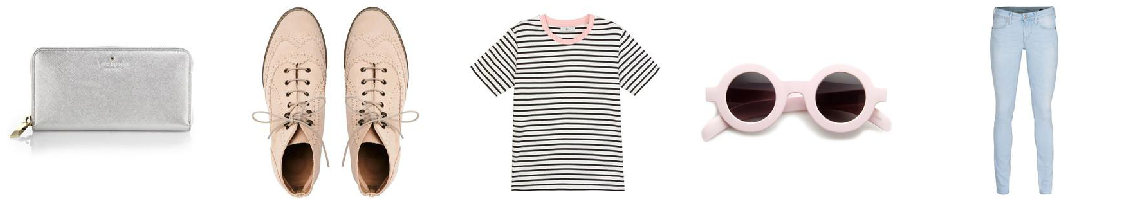

In [14]:
plot_pv_outfit(pv_train_pos[1000])

In [15]:
import pandas as pd

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X, y,
                 item_dict,
                 item_description,
                 image_dir,
                 batch_size,
                 max_len=16,
                 input_size=(224, 224, 3),
                 only_image=True,
                 shuffle=True):
        self.df = pd.DataFrame({'X': train_X, 'y': train_y})
        self.X = self.df['X'].tolist()
        self.y = self.df['y'].tolist()
        self.X_col = 'X'
        self.y_col = 'y'
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle        
        self.n = len(self.df)
        self.max_len = max_len
        self.only_image = only_image
        self.item_dict = item_dict
        self.item_description = item_description
        self.image_dir = image_dir
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def get_texts(self, item_id):
        item = self.item_description[item_id]  # item attributes
        return ' '.join([item['url_name'], item['description'], item['title'], item['semantic_category']])

    def get_image(self, item_id):
        image_path = os.path.join(self.image_dir, item_id + ".jpg")
        image = tf.keras.preprocessing.image.load_img(image_path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(self.input_size[0], self.input_size[1])).numpy()
        return image_arr/255.

    def __get_input(self, example):
        data = []
        items = [self.item_dict[x] for x in example]
        for item in items:
            text = self.get_texts(item)
            image = self.get_image(item)
            if self.only_image:
                data.append(image)
            else:
                data.append((text, image))
        if self.only_image:
            zeros = [np.zeros(self.input_size) for _ in range(self.max_len - len(data))]
        else:
            zeros = [('empty', np.zeros(self.input_size)) for _ in range(self.max_len - len(data))]
        return zeros + data

    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        x_batch = batches['X'].tolist()
        y_batch = batches['y'].tolist()

#         batch_X, batch_Y = [], []
#         for x, y in zip(x_batch, y_batch):
#             x_num = self.__get_input(x)
#             batch_X.append(np.vstack(x_num))
#             batch_Y.append(int(y))
            
#         print(batch_X, batch_Y)

        X_batch = np.asarray([self.__get_input(x) for x in x_batch])
        y_batch = np.asarray([int(y) for y in y_batch])

        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [16]:
traingen = CustomDataGen(train_X, train_y, item_dict, pv_items, image_dir, batch_size=32)
x, y = traingen[0]
x.shape, y.shape

((32, 16, 224, 224, 3), (32,))

## Load Pretrained Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300, 300, 3]),
    tf.keras.layers.Cropping2D(38),
#     tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.summary()

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 5,924,436
Trainable params: 5,863,828
Non-trainable params: 60,608
_________________________________________________________________


In [140]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300, 300, 3]),
    tf.keras.layers.Cropping2D(38)])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [11]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
image_dir = os.path.join(base_dir, "images")

item = '211212562'
image_path = os.path.join(image_dir, item + ".jpg")
img = Image.open(image_path)
img2 = plt.imread(image_path)
img.height, img.width, img2.shape

(300, 300, (300, 300, 3))

In [9]:
model(tf.expand_dims(img2, 0))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0826408e-04, 9.9989176e-01, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)>

In [14]:
get_texts(item)

'saint laurent monogram sunset leather   bags'

In [15]:
pv_items[item]

{'url_name': 'saint laurent monogram sunset leather',
 'description': '',
 'catgeories': '',
 'title': '',
 'related': '',
 'category_id': '40',
 'semantic_category': 'bags'}